                  time  y        x1        x2        x3         x4        x5  \
0  1999-05-01 00:00:00  0  0.376665 -4.596435 -4.095756  13.497687 -0.118830   
1  1999-05-01 00:02:00  0  0.475720 -4.542502 -4.018359  16.230659 -0.128733   
2  1999-05-01 00:04:00  0  0.363848 -4.681394 -4.353147  14.127997 -0.138636   
3  1999-05-01 00:06:00  0  0.301590 -4.758934 -4.023612  13.161566 -0.148142   
4  1999-05-01 00:08:00  0  0.265578 -4.749928 -4.333150  15.267340 -0.155314   

          x6        x7        x8  ...        x51        x52       x54  \
0 -20.669883  0.000732 -0.061114  ...  29.984624  10.091721 -4.936434   
1 -18.758079  0.000732 -0.061114  ...  29.984624  10.095871 -4.937179   
2 -17.836632  0.010803 -0.061114  ...  29.984624  10.100265 -4.937924   
3 -18.517601  0.002075 -0.061114  ...  29.984624  10.104660 -4.938669   
4 -17.505913  0.000732 -0.061114  ...  29.984624  10.109054 -4.939414   

         x55        x56       x57       x58       x59       x60  y.1  
0 -24.590

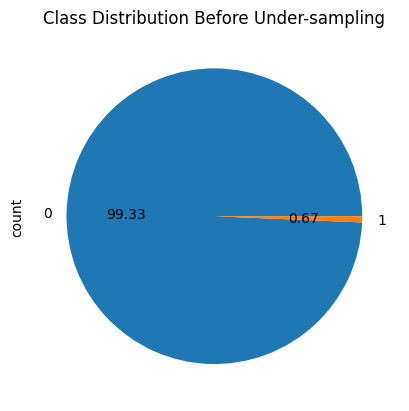

Training set shape: (248, 17), Testing set shape: (248, 17)


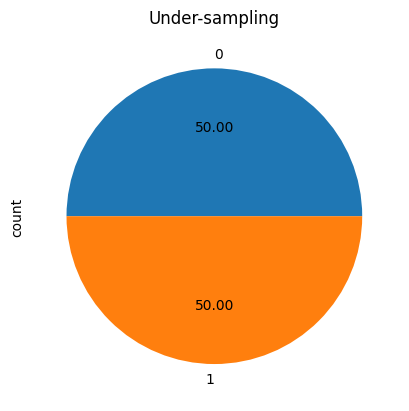

y
0    18274
1      124
Name: count, dtype: int64
Training set shape: (198, 17), Testing set shape: (50, 17)
Confusion Matrix:
[[14 12]
 [ 7 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.54      0.60        26
           1       0.59      0.71      0.64        24

    accuracy                           0.62        50
   macro avg       0.63      0.62      0.62        50
weighted avg       0.63      0.62      0.62        50

ROC-AUC score: 0.610576923076923
Confusion Matrix with Optimal Threshold:
[[15 11]
 [ 8 16]]

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.65      0.58      0.61        26
           1       0.59      0.67      0.63        24

    accuracy                           0.62        50
   macro avg       0.62      0.62      0.62        50
weighted avg       0.62      0.62      0.62        50



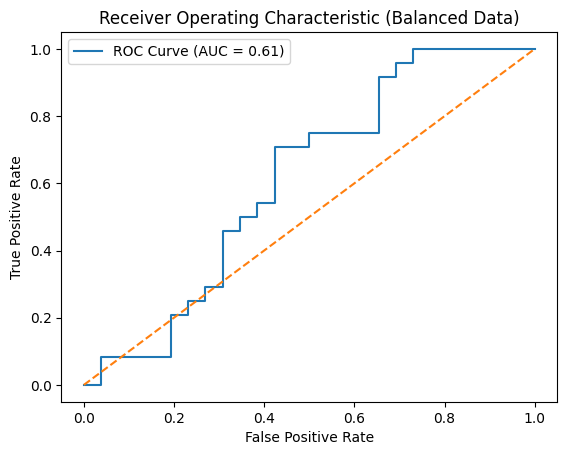

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler

# saving to csv
# data = pd.read_excel('data/AnomaData.xlsx', engine='openpyxl')
# data.to_csv('data/AnomaData.csv', index=False)  # Save as CSV

'''Data Loading and Exploration (EDA)'''
# Loading the data
data = pd.read_csv('../data/AnomaData.csv')

print(data.head(5))

# Data Quality check (missing values)
print("Missing values per column:")
print(data.isnull().sum())

# Display basic statistics
# print("Data description:")
# print(data.describe())

# Plot histograms of features
'''data.hist(figsize=(12, 10))
plt.show()
plt.savefig('visuals/features.png')'''

# Class distribution before balancing
data['y'].value_counts().plot.pie(autopct='%.2f', title="Class Distribution Before Under-sampling")
plt.savefig('../visuals/class_distribution_before_balancing.png')  # Save the pie chart before balancing
plt.show()

# Define features and target variable
X = data[['x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60']]
y = data['y']

# Balancing the dataset
rus = RandomUnderSampler(sampling_strategy=1)
X_res, y_res = rus.fit_resample(X, y)
print(f"Training set shape: {X_res.shape}, Testing set shape: {X_res.shape}")
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

# Save the pie chart after balancing
plt.savefig('../visuals/undersampling_pie_chart.png')
plt.show()

print(data['y'].value_counts())


# Split the data into training and testing sets
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train_res.shape}, Testing set shape: {X_test_res.shape}")


# Train the XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_res, y_train_res)

# Make predictions
y_pred_res = xgb_model.predict(X_test_res)


# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_res, y_pred_res))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_res, y_pred_res))

# ROC-AUC Score
y_probs_res = xgb_model.predict_proba(X_test_res)[:, 1]
roc_auc_res = roc_auc_score(y_test_res, y_probs_res)
print(f"ROC-AUC score: {roc_auc_res}")

fpr_res, tpr_res, thresholds_res = roc_curve(y_test_res, y_probs_res)
optimal_threshold_res = thresholds_res[np.argmax(tpr_res - fpr_res)]
y_pred_optimal_res = (y_probs_res > optimal_threshold_res).astype(int)

# Evaluate with the optimal threshold
print("Confusion Matrix with Optimal Threshold:")
print(confusion_matrix(y_test_res, y_pred_optimal_res))

print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test_res, y_pred_optimal_res))

# Saving the model to disk
import pickle
with open('../models/balanced_model.pkl', 'wb') as model_file:
    pickle.dump(xgb_model, model_file)


# Ploting ROC Curve
plt.figure()
plt.plot(fpr_res, tpr_res, label=f'ROC Curve (AUC = {roc_auc_res:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Balanced Data)')
plt.legend()
plt.savefig('../visuals/roc_curve_balanced.png')
plt.show()
